In [107]:
#Libraries import

import numpy as np
import pandas as pd
from library import Map
import math
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt
import matplotlib as mt
import random as rn
from random import randrange
from library import Map, GradientDescent
from sklearn.linear_model import SGDClassifier
from sklearn import tree
from library import DecisionTree as DT
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
import seaborn as sns
import scipy.spatial.distance as d
import heapq as hq

In [108]:
'''Data dowloading'''

#url='https://drive.google.com/file/d/12dUeEO_rkButPD79pOteFoSSeuIBg5qt/view?usp=drive_link'
#file_id=url.split('/')[-2]
#dwn_url='https://drive.google.com/uc?id=' + file_id
#dataset0 = pd.read_csv(dwn_url)

dataset0 = pd.read_csv("/Users/alessandrococcia/Downloads/ObesityDataSet.csv")

# Linear Regression
- To predict the weight values we find the minimum of the loss function MSE (mean squared error).
- We first preprocess datas with sampling, then mapping strings with one-hot-encode, normalizing the dataset and finally inserting bias column.
- The linear regression uses penrose pseudoinverse to compute the minimum of MSE, updating the weights of the multivariate function: $w^{*} = (X^{T}X)^{-1}X^{T}$ 

In [109]:
dataset = dataset0

'''sampling dataset'''
np.random.seed(42)
dataset = dataset.sample(frac=1, ignore_index=True)

dataset = pd.get_dummies(dataset, drop_first=True, dtype=float)

'''normalization'''
dataset = (dataset-dataset.mean())/dataset.std()

dataset.insert(0, "Bias", np.ones(len(dataset)), True) #Bias row

In [110]:
#Splitting dataset
TRAIN_TEST_SPLIT_PERCENTAGE = 0.9
dataset_training = dataset[:int(len(dataset) * TRAIN_TEST_SPLIT_PERCENTAGE)]
dataset_test = dataset[int(len(dataset) * TRAIN_TEST_SPLIT_PERCENTAGE):]

x = dataset_training.loc[:, dataset_training.columns != 'Weight']
y = dataset_training.loc[:, dataset_training.columns == 'Weight']

In [111]:
'''To compute loss function'''
class Error:
    
    def MSE(self, a, b):
        return np.mean((np.square(a - b)))
    def RMSE(self, a, b):
        return math.sqrt(np.mean(np.square(a - b)))
    def MAE(self, a, b):
        return np.mean(abs(a-b))


In [112]:
e = Error()

yStripped = y.values
xStripped = x.values
#Moore-Penrose pseudoinverse
pseudoinverse = np.linalg.inv(np.matmul(xStripped.T, xStripped))
#Wheights
c = np.matmul(pseudoinverse, np.matmul(xStripped.T, yStripped))

'''TESTING'''
dt = dataset_test
dtX = dt.loc[:, dt.columns != 'Weight']
dtY = dt.loc[:, dt.columns == 'Weight']

dtY = dtY.values
prediction = np.matmul(dtX, c)

'''Errors estimations'''
mse = e.MSE(dtY, prediction)
rmse = e.RMSE(dtY, prediction)
mae = e.MAE(dtY, prediction)

'''sklearn'''
reg = LinearRegression().fit(xStripped, yStripped)
scikit_predict = reg.predict(dtX.values)


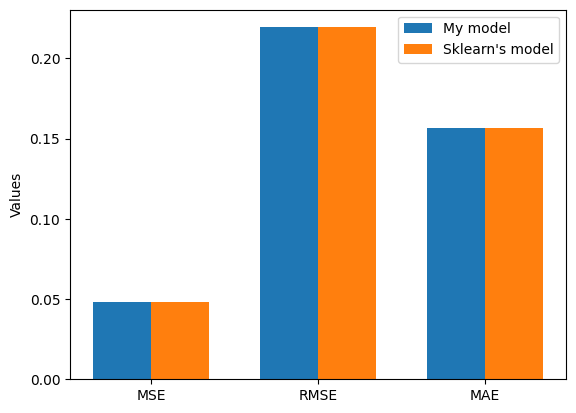

In [113]:

'''Array with my results'''
my_results = [mse, rmse, mae]

'''Array with sklearn's results'''
sklearn_results = [e.MSE(dtY, scikit_predict), e.RMSE(dtY, scikit_predict), e.MAE(dtY, scikit_predict)]

labels = ['MSE', 'RMSE', 'MAE']

'''Label positioning'''
x = np.arange(len(labels))  
width = 0.35  #Bar width

fig, ax = plt.subplots()
rects1 = ax.bar(x - width/2, my_results, width, label='My model')
rects2 = ax.bar(x + width/2, sklearn_results, width, label='Sklearn\'s model')

'''Labeling'''
ax.set_ylabel('Values')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()

plt.show()

# Gradient descent for linear regression
- To predict the output of our function we minimize the loss function MSE.
- To find the minimum, instead of using the pseudoinverse of Penrose we take tiny steps in the direction opposite to the gradient of the loss. 
- This process is iterated until the gradient is little as our desire.
- This is the alghoritm: $$\begin{align*}
&w \leftarrow \text{any point in the parameter space}\\
&\text{while not converged do}\\
&\qquad \text{for each }w_{i} \text{ in } w \text{ do }\\
&\quad\quad\qquad w_{i}\leftarrow w_{i}-\alpha {\partial\over \partial w_{i}}Loss(w) 
\end{align*}$$
- The alghoritm i wrote uses also the stochastic method: instead of giving in input the whole dataset, i choose a minibatch of random samples.
- The difference between the two methods is apparent at the end of this section. 

In [114]:
'''Downloading dataset'''
dataset = dataset0

'''Dataset sampling'''
dataset = dataset.sample(frac=1, ignore_index=True) #shuffle sample in the training set

'''mapping delle stringhe'''

dataset = pd.get_dummies(dataset, drop_first=True, dtype=float)

'''normalization'''
dataset =(dataset-dataset.mean())/dataset.std()

'''Inserimento colonna di bias'''
dataset.insert(0, "Bias", np.ones(len(dataset)), True) #Bias row

#Splitting dataset
TRAIN_SPLIT_PERCENTAGE = 0.8
VALIDATION_SPLIT_PERCENTAGE = 0.1
TEST_SPLIT_PERCENTAGE = 0.1
dataset_training = dataset[:int(len(dataset) * TRAIN_SPLIT_PERCENTAGE)]
dataset_validation = dataset[int(len(dataset) * TRAIN_SPLIT_PERCENTAGE):int(len(dataset) * (TRAIN_SPLIT_PERCENTAGE + VALIDATION_SPLIT_PERCENTAGE))]
dataset_test = dataset[int(len(dataset) * (TRAIN_SPLIT_PERCENTAGE + VALIDATION_SPLIT_PERCENTAGE)):]


In [115]:

class GradientDescent:
    def __init__(self, learningrate, epochs, parameters_length, output_string, batch_size): 
        self.learningrate = learningrate
        self.epochs = epochs
        self.parameters_length = parameters_length
        self.parameters = None
        self.output_string = output_string
        self.len_totale = None
        self.batch_size = batch_size

    def SGD(self, training_set):
        
        '''Wheight initialization'''
        self.parameters = np.ones(self.parameters_length)
        '''Su input e output totale calcolerò ad ogni n-esima epoca l'errore'''
        total_input = training_set.loc[:len(training_set), training_set.columns != self.output_string]
        total_output = training_set.loc[:len(training_set), training_set.columns == self.output_string]
        self.len_totale = len(training_set)

        '''ciclo for per le epoche'''
        '''Batch == total input: do not need to randomize the dataset'''
        if self.batch_size == self.len_totale:
            input = total_input
            output = total_output
            for i in range(self.epochs):
                gradient = self.gradient(input, output)
                self.SGD_aux(gradient)
        
        else:
            '''for minibatch'''
            for i in range(self.epochs):
                batch = training_set.sample(n=self.batch_size)
                input = batch.loc[:, training_set.columns != self.output_string]
                output = batch.loc[:, training_set.columns == self.output_string]
                gradient = self.gradient(input, output)
                self.SGD_aux(gradient)
                
        return self.parameters

    '''updating the weights'''
    def SGD_aux(self, gradient):
        self.parameters -= self.learningrate*gradient

    '''calculating the gradient of error'''
    def gradient(self, input, output): 
        output = np.array(output).T
        prediction = self.prediction(input)
        error = prediction-output
        return np.matmul(error, input)/input.shape[0] #the error is normalized by the number of samples

    def prediction(self, input):
        return np.dot(input.values, self.parameters)



# Grid search
- the idea is to test the model with different hyperparameters. 
- We compute a grid search to find the best hyperparameters for the model.
- For the grid serach we have to differentiate between 3 sets: training set, validation set and test set. To validate the efficacy of hyperparameter combination we have to use validiation. If we don't do this we risk overfitting.
- The grid search has |lr|*|e|*|batch_size| possible combinations of hyperparameters.

In [116]:
lr = 1e-1, 1e-2, 1e-3 #learning rate
e = 100, 500, 1000, 3000 #epochs
batch_size = 1, 50, 100, 500, dataset_training.shape[0] #batch size

#initialize the grid search
hyperparameter_list = np.zeros((len(lr), len(e), len(batch_size), dataset_training.shape[1]-1))

for i in range(len(lr)):
    for h in range(len(e)):
        for g in range(len(batch_size)):
            gd = GradientDescent(learningrate=lr[i], epochs=e[h], parameters_length=dataset_training.shape[1]-1, output_string='Weight', batch_size=batch_size[g])
            hyperparameter_list[i][h][g] = gd.SGD(dataset_training)

In [117]:
batch_test = hyperparameter_list
X_validation = np.array(dataset_validation.loc[:, dataset_validation.columns != 'Weight'])
Y_effettivo = np.array(dataset_validation['Weight'])


# To store the errors for each combination of hyperparameters
errors = np.zeros((len(lr), len(e), len(batch_size)))

map = Map()
for i in range(len(lr)):
  for h in range(len(e)):
    for g in range(len(batch_size)):
        Y_predetto = np.array(np.matmul(X_validation, batch_test[i][h][g]))
        errors[i][h][g] = map.MSE(Y_effettivo, Y_predetto)


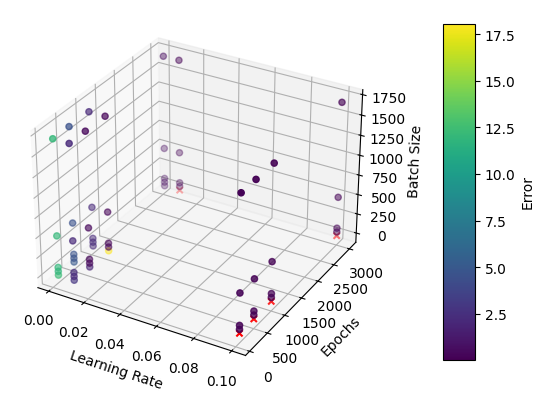

In [118]:

lr_list, e_list, batch_size_list, error_list = [], [], [], []
error_threshold = 20 #This threshold is used to identify outliers
outliers = []

for i in range(len(lr)):
    for h in range(len(e)):
        for g in range(len(batch_size)):
            error_value = errors[i, h, g]
            if error_value < error_threshold:
                lr_list.append(lr[i])
                e_list.append(e[h])
                batch_size_list.append(batch_size[g])
                error_list.append(errors[i, h, g])
            else:
                #outliers are put in a separate list
                outliers.append((lr[i], e[h], batch_size[g], errors[i, h, g]))


# Create a 3D scatter plot
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# Plotting the data
sc = ax.scatter(lr_list, e_list, batch_size_list, c=error_list, cmap='viridis')

# Plotting the outliers with a different color and marker
outliers_lr, outliers_e, outliers_batch_size, outliers_error = zip(*outliers)
ax.scatter(outliers_lr, outliers_e, outliers_batch_size, c='red', marker='x')


# Adding labels
ax.set_xlabel('Learning Rate')
ax.set_ylabel('Epochs')
ax.set_zlabel('Batch Size')


# Adjust the position of the colorbar
fig.subplots_adjust(right=0.8)  # Adjust the right boundary of the plot window
cbar_ax = fig.add_axes([0.85, 0.15, 0.05, 0.7])  # Add an axes at position [left, bottom, width, height]
colorbar = fig.colorbar(sc, cax=cbar_ax)  # Draw the colorbar in the newly created axes
colorbar.set_label('Error')


# Show plot
plt.show()

## Results
- On the three axes there are the hyperparameters.
- The color scale is used to mark the output results.
- We can see from the graph that with batch size = 1, the model performs the worst as the model generates lots of outliers.
- Some of the best results are appreciated in the area with batch size 50, 100, 500, 1899, epochs 100, 500, 1000, 3000 and learning rate 0.1

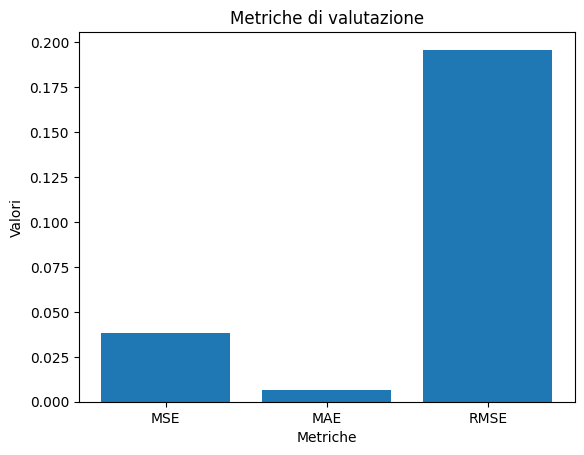

In [119]:
'''Let's use the best hyperparameters on the test set'''
# Getting indexes of the best hyperparameters
min_error_index = error_list.index(min(error_list))

# Estraggo i migliori iperparametri
best_layer = lr_list[min_error_index]
best_e = e_list[min_error_index]
best_batch = batch_size_list[min_error_index]

layer_index = lr.index(best_layer)
e_index = e.index(best_e)
batch_index = batch_size.index(best_batch)

X_test = np.array(dataset_test.loc[:, dataset_test.columns != 'Weight'])
Y_test = np.array(dataset_test['Weight'])
test_results = np.matmul(X_test, batch_test[layer_index][e_index][batch_index])

# Calcola i valori di MSE, MAE e RMSE
mse = np.mean((test_results - Y_test) ** 2)
mae = abs(np.mean((test_results - Y_test)))
rmse = mse ** 0.5

# Crea una lista con i nomi delle metriche
metriche = ['MSE', 'MAE', 'RMSE']

# Crea una lista con i valori delle metriche
valori = [mse, mae, rmse]

# Plotta i valori delle metriche
plt.bar(metriche, valori)
plt.xlabel('Metriche')
plt.ylabel('Valori')
plt.title('Metriche di valutazione')
plt.show()

# Decision Trees
- In this section we use a decision tree to classify our samples.
- The decision tree is a data structure which is builts to map a vector of attribute values to a single output, which is the decision, or in other words the classification.
- In this case we compute a boolean classification, giving every sample the attribute 1 if the person is obese or 0 if not.
- the structure of the algorithm is the following: $$\begin{align*}
&\text{function LEARN-DECISION-TREE(example, attributes, parent-examples)}\\
&\quad \text{if examples is empty then return PLURALITY-VALUE(parent-examples)}\\
&\quad \text{else if all examples have the same classification the return the classification}\\
&\quad \text{else if attributes is empty then return PLURALITY-VALUE(examples)}\\
&\quad \text{else}\\
&\quad\quad A \leftarrow argmax_{a\in attributes}IMPORTANCE(a, examples)\\
&\quad\quad tree\leftarrow \text{a new decision tree with root test A}\\
&\quad\quad \text{for each value } v \text{ of A do}\\
&\quad\quad\quad exs\leftarrow \{ e : \in examples \text{ and } e.A=v \}\\
&\quad\quad\quad subtree \leftarrow LEARN-DECISION-TREE(exs, attributes-A, examples)\\
&\quad\quad\quad \text{add a branch to tree with label (A=v) and subtree } subtree\\
	&\quad\quad return \;tree
\end{align*}$$
- The algorithm has some important functions which let us decide how to divide the tree and form the branches.
- The importance of an attributes is defined in terms of Entropy. In this case the entropy of our boolean random variable that is true with probability $q$ has cost function $$B(q) = -(q\log_{2}q+(1-q)\log_{2}(1-q))$$
- The entropy of the whole set is calculated as $$H(output) = B\left({p\over p+n}\right)$$
- The expected entropy remaining after testing an attribute A is: $$Remainder(A) = \sum^{d}_{k=1} {p_{k}+n_{k}\over p+n}B\left({{p_k\over p_{k}+n_{k}}}\right)$$
- So to choose which is the best attribute we use the remainder and the $B$ function to obtain the Gain in information: $$Gain(A) = B\left( {\frac{p}{p+n}} \right)-Remainder(A)$$
- Testing on all remaining attributes will give us the best decision to take

In [120]:
'''Obesity'''
dataset = dataset0

'''data manipulation'''
'''We round the data, otherwise we would have too many values for a single feature, leading to overfitting'''
dataset = dataset.round(0) 
dataset = dataset.sample(frac=1, ignore_index=True) #shuffle sample in the training set
dataset.replace(to_replace=("Insufficient_Weight", "Normal_Weight", "Overweight_Level_I", "Overweight_Level_II"), value=0, inplace=True)
dataset.replace(to_replace=("Obesity_Type_I", "Obesity_Type_II", "Obesity_Type_III"), value=1, inplace=True)


'''Mappo le stringhe in interi'''
e = Error()
dataset = pd.get_dummies(dataset, drop_first=True, dtype=float)


TRAIN_TEST_SPLIT_PERCENTAGE = 0.90
dataset_training = dataset[:int(len(dataset) * TRAIN_TEST_SPLIT_PERCENTAGE)]
dataset_test = dataset[int(len(dataset) * TRAIN_TEST_SPLIT_PERCENTAGE):]
dataset_test.reset_index(drop=True, inplace=True)

/var/folders/yq/gyf11wn125qgkzlcv24mbp3w0000gn/T/ipykernel_22041/2821649434.py:9: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  dataset.replace(to_replace=("Obesity_Type_I", "Obesity_Type_II", "Obesity_Type_III"), value=1, inplace=True)


In [121]:
'''Library for decision Tree'''
    
class DecisionTree:
    def __init__(self, outputstring, positive, negative): 
        self.outputstring = outputstring
        self.positive = positive
        self.negative = negative
        self.nodes = [] #a list for the future children
        self.label = None

    def LearnDecisionTree(self, examples, attributes, parent_examples, column_values):
        same_classification = self.SameClassification(examples)    
        
        if len(examples.loc[:, examples.columns != self.outputstring]) == 0:
            return self.PluralityValue(parent_examples)
        elif same_classification is not False:
            return same_classification
        elif len(attributes) == 0: 
            return self.PluralityValue(examples)
        else:
            '''Choosing the best attribute based on the entropy'''
            bestattribute = self.Importance(attributes, examples)
            self.label = bestattribute #Seleziono l'attributo migliore
            
            for value in self.Values1(bestattribute, column_values):
                remainingexamples = self.Examples(bestattribute, examples, value)
                tree = DecisionTree(self.outputstring, self.positive, self.negative)
                attributes_left = self.PopListValue(attributes.copy(), bestattribute)                
                subtree = tree.LearnDecisionTree(remainingexamples.loc[:, remainingexamples.columns != bestattribute], attributes_left, examples, column_values)
                '''Every node of the subtree has a list of tuples, where the first element is the value of the attribute and the second element is the subtree.
                To easily test the tree, we will then check the value of the attribute and then we will go to the subtree.'''
                self.nodes.append((value, subtree))
        return self
        
    '''How much is important an attribute?'''
    def Importance(self, attributes, examples): 
        max = -1
        ret = None
        for a in attributes:
            loc = self.Gain(examples, a)
            if loc > max:
                max = loc
                ret = a
        return ret
        
    '''B function'''
    def B(self, q):
        if q == 1 or q == 0:
            return 0
        return -(q*math.log2(q)+(1-q)*math.log2(1-q))
    
    def Remainder(self, examples, attribute, p, n):
        sum = 0
        for v in self.Values2(attribute, examples):
            if type(v) is not str and math.isnan(float(v)):
                pk = len(examples.loc[(examples[self.outputstring] == self.positive) & (examples[attribute].isnull())])
                nk = len(examples.loc[(examples[self.outputstring] == self.negative) & (examples[attribute].isnull())])
            else:
                pk = len(examples.loc[(examples[self.outputstring] == self.positive) & (examples[attribute] == v)])
                nk = len(examples.loc[(examples[self.outputstring] == self.negative) & ((examples[attribute] == v))])
            
            partial = (pk+nk)*self.B(pk/(pk+nk))
            sum += partial
        return (1/(p+n))*sum
    
    def Gain(self, examples, attribute):
        p = len(examples.loc[examples[self.outputstring] == self.positive])
        n = len(examples.loc[examples[self.outputstring] == self.negative])
        b = self.B(p/(p+n))
        r = self.Remainder(examples, attribute, p, n)
        return (b-r)
        
    def PluralityValue(self, parent_examples): 
        '''Selects the most common ouput value among a set of examples, breaking ties randomly'''
        value, max = [], 0
        d = self.CreateDictionary(parent_examples)
        for key in d.keys():
            if d.get(key) > max:
                max = d.get(key)
                value = []
                value.append(key)
            elif d.get(key) == max:
                '''If there is a tie, we will randomly choose one of the two values'''
                value.append(key)
        return rn.choice(value)
        
    def SameClassification(self, examples): 
        if (len(examples) == 0):
            return False
        d = self.CreateDictionary(examples)
        if (len(d.keys()) == 1):
            return list(d.keys())[0]
        return False
    def CreateDictionary(self, examples):
        examples = examples[self.outputstring].tolist()
        d = {}
        for i in range(len(examples)):
            if d.get(examples[i]) is None:
                d[examples[i]] = 1
            else:
                d[examples[i]] += 1
        return d

    def Values1(self, attribute, dictionary): 
        return list(dictionary.get(attribute))
    
    def Values2(self, attribute, examples):
        return examples[attribute].unique()

    def Examples(self, attribute, examples, value):
        exs = examples.loc[examples[attribute] == value]
        return exs
    def PopListValue(self, lista, value):
        if value not in lista:
            return None
        lista.remove(value)
        return lista 

    def Prediction(self, input):
        for i in range(len(self.nodes)):
            x = input[self.label].values[0]
            '''Check if values is Nan or not'''
            if type(self.nodes[i][0]) is not str and math.isnan(float(self.nodes[i][0])):
                if type(x) is not str and math.isnan(float(x)):
                    if type(self.nodes[i][1]) is DecisionTree:
                        return self.nodes[i][1].Prediction(input)
                    return self.nodes[i][1]
            elif self.nodes[i][0] == x:
                if type(self.nodes[i][1]) is DecisionTree:
                    return self.nodes[i][1].Prediction(input)
                return self.nodes[i][1]
        return 1


In [122]:
'''TRAINING'''

'''initalization for decision tree columns'''
d = {}
for elem in dataset_training.columns:
    d[elem] = set()
    for elem1 in dataset_training[elem]:
        d[elem].add(elem1)

my_decisionTree = DecisionTree('NObeyesdad', 1, 0)
attributes1 = my_decisionTree.PopListValue(dataset_training.columns.tolist(), 'NObeyesdad')
my_decisionTree.LearnDecisionTree(dataset_training, attributes1, dataset_training, d)


X = dataset_training.loc[:, dataset_training.columns != 'NObeyesdad']
Y = dataset_training.loc[:, dataset_training.columns == 'NObeyesdad']
Z = dataset_test.loc[:, dataset_test.columns != 'NObeyesdad']
clf = tree.DecisionTreeClassifier(criterion='entropy')
clf = clf.fit(X, Y)


## Metrics for classification

- To calculate how our model is good we use different types of metrics:

- Accuracy: $$Accuracy = \left| \frac{\text{Correct prediction}}{Total prediction}\right|$$

- Confusion matrix: grid which has predicted output as columns and real output as as rows

- Precision: gives a measure for how much we can trust a positive prediction of our model $$Precision = {TP\over TP+FP}$$
- Recall: gives a measure of how many real true values are detected$$Recall = {TP\over TP+FN}$$

- F1 score: is defined as the harmonic mean of precision and recall $$F_{1}={2*precision*recall\over precision+recall}$$

- AUC: it is the area under the curve (usually of ROC). It is also equal to the probability that our classifier will predict a higher score for a random positive example


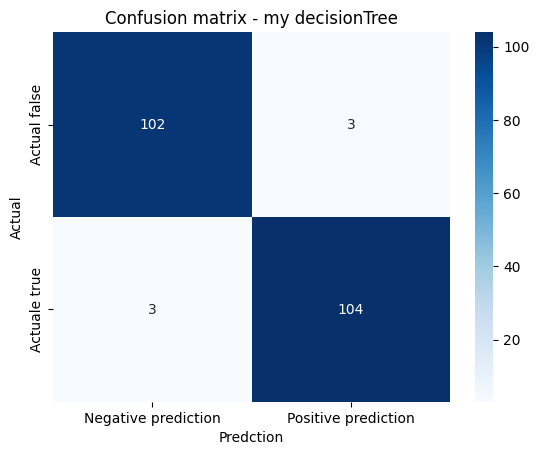

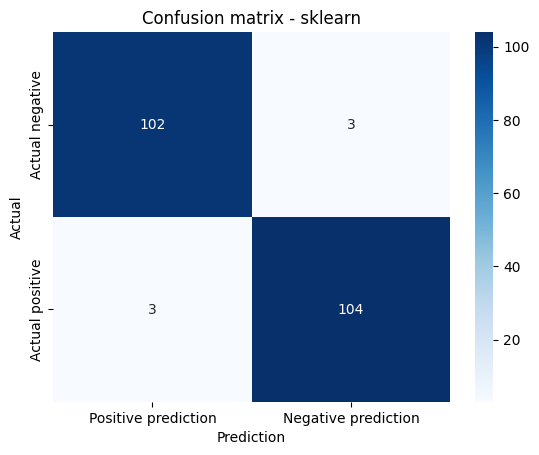

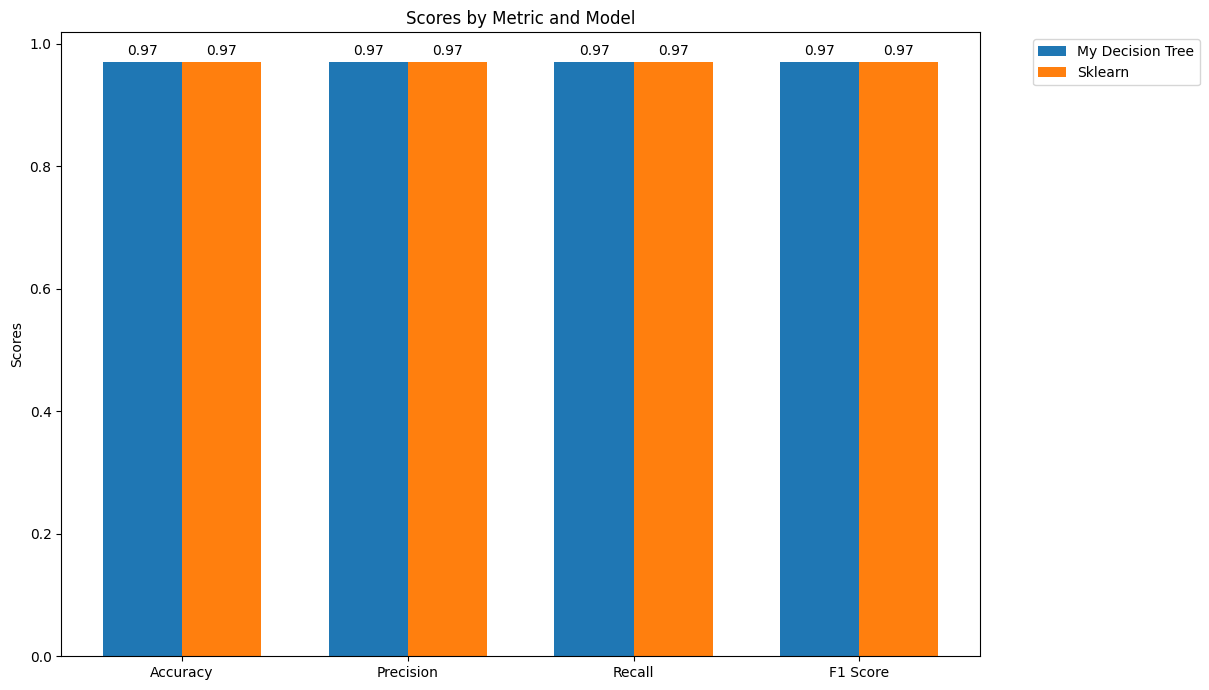

In [123]:
'''my prediction'''

my_prediction = []

for i in range(dataset_test.shape[0]):
    input = dataset_test.loc[i:i]
    prediction = my_decisionTree.Prediction(input)
    my_prediction.append(prediction)

test_column = list(dataset_test['NObeyesdad'].values)

'''My metrics'''
accuracy = metrics.accuracy_score(test_column, my_prediction)
cm = metrics.confusion_matrix(test_column, my_prediction)
precision = metrics.precision_score(test_column, my_prediction, average='weighted')
recall = metrics.recall_score(test_column, my_prediction, average='weighted')
f1_score = metrics.f1_score(test_column, my_prediction, average='weighted')

'''Sklearn metrics'''
sklearn_prediction = clf.predict(Z)
sk_accuracy = metrics.accuracy_score(test_column, sklearn_prediction)
sk_cm = metrics.confusion_matrix(test_column, sklearn_prediction)
sk_precision = metrics.precision_score(test_column, sklearn_prediction, average='weighted')
sk_recall = metrics.recall_score(test_column, sklearn_prediction, average='weighted')
sk_f1_score = metrics.f1_score(test_column, sklearn_prediction, average='weighted')


'''Confusion matrix my model'''
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Negative prediction', 'Positive prediction'], yticklabels=['Actual false', 'Actuale true'])
plt.xlabel('Predction')
plt.ylabel('Actual')
plt.title('Confusion matrix - my decisionTree')
plt.show()

'''Confusion matrix sklearn'''
sns.heatmap(sk_cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Positive prediction', 'Negative prediction'], yticklabels=['Actual negative', 'Actual positive'])
plt.xlabel('Prediction')
plt.ylabel('Actual')
plt.title('Confusion matrix - sklearn')
plt.show()

my_metrics = [round(accuracy, 2), round(precision, 2), round(recall, 2), round(f1_score, 2)]
sklearn_metrics = [round(sk_accuracy, 2), round(sk_precision, 2), round(sk_recall, 2), round(sk_f1_score, 2)]

# Etichette per le metriche
labels = ['Accuracy', 'Precision', 'Recall', 'F1 Score']

# Per il grafico a barre
x = np.arange(len(labels))  # the label locations
width = 0.35  # the width of the bars

fig, ax = plt.subplots(figsize=(10, 7))

rects1 = ax.bar(x - width/2, my_metrics, width, label='My Decision Tree')
rects2 = ax.bar(x + width/2, sklearn_metrics, width, label='Sklearn')

# Aggiunta di etichette, titolo e legenda
ax.set_ylabel('Scores')
ax.set_title('Scores by Metric and Model')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()

# Funzione per aggiungere le etichette ai dati
def autolabel(rects):
    """Attach a text label above each bar in *rects*, displaying its height."""
    for rect in rects:
        height = rect.get_height()
        ax.annotate('{}'.format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')

autolabel(rects1)
autolabel(rects2)

fig.tight_layout()

# Aggiungi alcune etichette di testo, titolo e legenda
ax.set_ylabel('Scores')
ax.set_title('Scores by Metric and Model')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

plt.show()



# Logistic Regression
-  To classify our test sample in this section we use the logistic regression.
- The logistic regression tunes the weigths based on the derivate of the logistic function: $$Logistic(z) = {1\over 1+e^{-z}}$$ where $z = w\cdot x$
- The output of  this function is a number in the interval $(0,1)$. To decide which is the output value for the classification we use a threshold value: if the output is above the threshold we stick it to 1, to 0 otherwise.
- The update of the weights uses the gradient descent following the formula: $$w_{i}\leftarrow w_{i}+\alpha(y-h_{w}(x))\times h_{w}(x)(1-h_{w}(x))\times x_{i}$$ were $y$ is the real output ad $h_{w}$ is the logistic outputm, our prediction.

In [124]:
'''Downloading dataset'''
dataset = dataset0

'''Dataset sampling'''
dataset = dataset.sample(frac=1, ignore_index=True) #shuffle sample in the training set

'''mapping delle stringhe'''
dataset.replace(to_replace=("Insufficient_Weight", "Normal_Weight", "Overweight_Level_I", "Overweight_Level_II"), value=0, inplace=True)
dataset.replace(to_replace=("Obesity_Type_I", "Obesity_Type_II", "Obesity_Type_III"), value=1, inplace=True)
dataset = pd.get_dummies(dataset, drop_first=True, dtype=float)

'''normalization'''
dataset = (dataset-dataset.mean())/dataset.std()

'''Inserimento colonna di bias'''
dataset.insert(0, "Bias", np.ones(len(dataset)), True) #Bias row


TRAIN_TEST_SPLIT_PERCENTAGE = 0.9
dataset_training = dataset[:int(len(dataset) * TRAIN_TEST_SPLIT_PERCENTAGE)]
dataset_test = dataset[int(len(dataset) * TRAIN_TEST_SPLIT_PERCENTAGE):]


/var/folders/yq/gyf11wn125qgkzlcv24mbp3w0000gn/T/ipykernel_22041/138891753.py:9: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  dataset.replace(to_replace=("Obesity_Type_I", "Obesity_Type_II", "Obesity_Type_III"), value=1, inplace=True)


In [125]:
class LogisticRegression_:
    def __init__(self, learningrate, epochs, parameters_length, output_string, batch_size, threshold, output_values, output_totale): 
        self.learningrate = learningrate
        self.epochs = epochs
        self.parameters_length = parameters_length
        self.parameters = None
        self.len_totale = None
        self.batch_size = batch_size
        self.threshold = threshold
        self.output_values = output_values
        self.output_string = output_string
        self.output_totale = output_totale

    def Descent(self, training_set):
        
        '''Initializing weights'''
        self.parameters = np.ones(self.parameters_length)

        input_totale = training_set.loc[:len(training_set), training_set.columns != self.output_string]
        output_totale = training_set.loc[:len(training_set), training_set.columns == self.output_string]
        self.len_totale = len(training_set)

        '''ciclo for per le epoche'''
        '''Batch == input totale: non devo randomizzare'''
        if self.batch_size == self.len_totale:
            input = input_totale
            output = output_totale
            for i in range(self.epochs):
                update = self.WeightsUpdate(input, output)
                self.Descent_aux(update)
        
        else:
            '''Uses minibatch'''
            for i in range(self.epochs):
                batch = training_set.sample(n=self.batch_size)
                input = batch.loc[:, training_set.columns != self.output_string]
                output = batch.loc[:, training_set.columns == self.output_string]
                
                update = self.WeightsUpdate(input, output)
                self.Descent_aux(update)
                
        return self.parameters

    '''to update weights'''
    def Descent_aux(self, update):
        self.parameters -= self.learningrate*update

    '''to calculate the gradient of the error'''
    def WeightsUpdate(self, input, output): 
        hw = self.Sigmoid(input)
        output = np.array(output.T)[0]
        error = np.array(hw-output)
        partial = error * hw * (1 - hw)
        return np.dot(input.T, partial.T).T/input.shape[0] #the error is normalized by the number of samples
    
    def Sigmoid(self, input):
        return 1 / (1 + np.exp(-np.dot(input, self.parameters))) 
        
    def prediction(self, input):
        return np.dot(input, self.parameters)

    def MSE(self, prediction, output):
        output = np.array(output)
        return np.mean((output - prediction)**2)
    def RMSE(self, prediction, output):
        return math.sqrt(np.mean((output - prediction)**2))
    
        

In [126]:
from sklearn.linear_model import LogisticRegression

'''My model's training'''

output_string = 'NObeyesdad'
input_totale = dataset_training.loc[:len(dataset_training), dataset_training.columns != output_string]
output_totale = dataset_training.loc[:len(dataset_training), dataset_training.columns == output_string]

'''Max and min values of the output column'''
positive_value, negative_value = max(output_totale['NObeyesdad'].unique()), min(output_totale['NObeyesdad'].unique())
threshold = 0.5

lr = LogisticRegression_(learningrate=1, epochs=3000, parameters_length=dataset_training.shape[1]-1, 
                        output_string=output_string, batch_size=dataset_training.shape[0], threshold=threshold, 
                        output_values=(positive_value, negative_value), output_totale=output_totale)
pesi = lr.Descent(dataset_training)

'''sklearn's training'''

model = LogisticRegression(max_iter=3000)
# Sk_learn training
output_totale[output_totale > threshold] = 1
output_totale[output_totale <= threshold] = 0
model.fit(input_totale, output_totale)



/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LogisticRegression(max_iter=3000)

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(


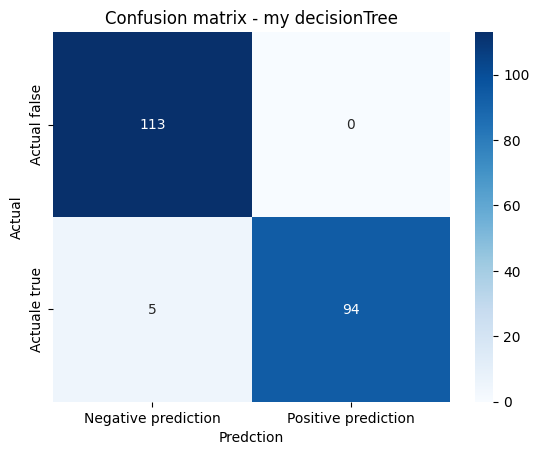

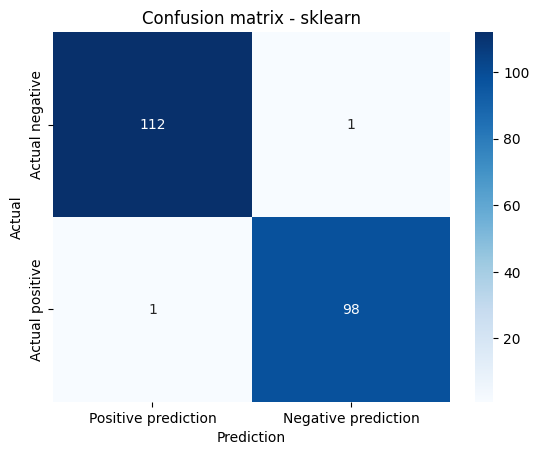

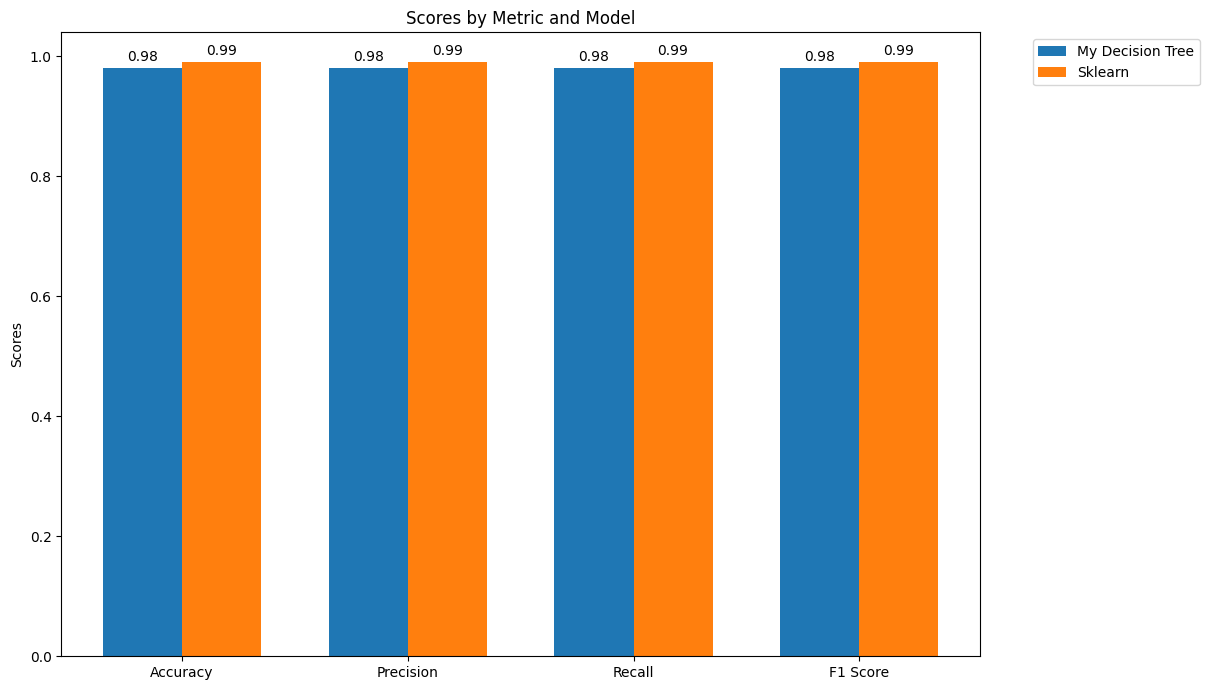

In [127]:
'''my prediction'''

X_test = np.array(dataset_test.loc[:, dataset_test.columns != 'NObeyesdad'])
test_column = np.array(dataset_test['NObeyesdad'])

'''the predicted values have to stick to 0 or 1'''
def LogisticFunction2(input, pesi, threshold):
        array = 1 / (1 + np.exp(-np.dot(input, pesi)))
        array[array > threshold] = 1
        array[array <= threshold] = 0
        return array

my_prediction = LogisticFunction2(X_test, pesi, lr.threshold)
test_column = np.array(dataset_test['NObeyesdad'].values)
'''Set output test values to 0 and 1'''
test_column[test_column > threshold] = 1
test_column[test_column <= threshold] = 0


'''My metrics'''
accuracy = metrics.accuracy_score(test_column, my_prediction)
cm = metrics.confusion_matrix(test_column, my_prediction)
precision = metrics.precision_score(test_column, my_prediction, average='weighted')
recall = metrics.recall_score(test_column, my_prediction, average='weighted')
f1_score = metrics.f1_score(test_column, my_prediction, average='weighted')

'''Sklearn metrics'''
sklearn_prediction = model.predict(X_test)
sk_accuracy = metrics.accuracy_score(test_column, sklearn_prediction)
sk_cm = metrics.confusion_matrix(test_column, sklearn_prediction)
sk_precision = metrics.precision_score(test_column, sklearn_prediction, average='weighted')
sk_recall = metrics.recall_score(test_column, sklearn_prediction, average='weighted')
sk_f1_score = metrics.f1_score(test_column, sklearn_prediction, average='weighted')


'''Confusion matrix my model'''
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Negative prediction', 'Positive prediction'], yticklabels=['Actual false', 'Actuale true'])
plt.xlabel('Predction')
plt.ylabel('Actual')
plt.title('Confusion matrix - my decisionTree')
plt.show()

'''Confusion matrix sklearn'''
sns.heatmap(sk_cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Positive prediction', 'Negative prediction'], yticklabels=['Actual negative', 'Actual positive'])
plt.xlabel('Prediction')
plt.ylabel('Actual')
plt.title('Confusion matrix - sklearn')
plt.show()

my_metrics = [round(accuracy, 2), round(precision, 2), round(recall, 2), round(f1_score, 2)]
sklearn_metrics = [round(sk_accuracy, 2), round(sk_precision, 2), round(sk_recall, 2), round(sk_f1_score, 2)]

# Etichette per le metriche
labels = ['Accuracy', 'Precision', 'Recall', 'F1 Score']

# Per il grafico a barre
x = np.arange(len(labels))  # the label locations
width = 0.35  # the width of the bars

fig, ax = plt.subplots(figsize=(10, 7))

rects1 = ax.bar(x - width/2, my_metrics, width, label='My Decision Tree')
rects2 = ax.bar(x + width/2, sklearn_metrics, width, label='Sklearn')

# Aggiunta di etichette, titolo e legenda
ax.set_ylabel('Scores')
ax.set_title('Scores by Metric and Model')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()

# Funzione per aggiungere le etichette ai dati
def autolabel(rects):
    """Attach a text label above each bar in *rects*, displaying its height."""
    for rect in rects:
        height = rect.get_height()
        ax.annotate('{}'.format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')

autolabel(rects1)
autolabel(rects2)

fig.tight_layout()

# Aggiungi alcune etichette di testo, titolo e legenda
ax.set_ylabel('Scores')
ax.set_title('Scores by Metric and Model')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()



# Knn
- To classify output values of test we check the distance to the nearest points of training dataset.
- If we choose k nearest neighbors we can decide which output approximate the most our sample.
- In this model when we have $k\neq 1$ we take the maximum occurrence between the k-samples
- To calculate the distance in a p-dimensional space we use the Minkowsky distance: $$\left(\sum^{n}_{i=1}|x_i-y_i|^{p}\right)^{1/p}$$
- The best results are found if we choose $k=1$
- To find the $knn$ i used a minheap which creates in O(nlogn) time a structure from which i can later extract the k points.
- To fasten the calculation i used scipy to compute Minkowsky distance

In [128]:
'''Downloading dataset'''
dataset = dataset0

'''Dataset sampling'''
dataset = dataset.sample(frac=1, ignore_index=True) #shuffle sample in the training set

'''mapping delle stringhe'''
dataset.replace(to_replace=("Insufficient_Weight", "Normal_Weight", "Overweight_Level_I", "Overweight_Level_II"), value=0, inplace=True)
dataset.replace(to_replace=("Obesity_Type_I", "Obesity_Type_II", "Obesity_Type_III"), value=1, inplace=True)
dataset = pd.get_dummies(dataset, drop_first=True, dtype=float)

'''normalization'''
dataset = (dataset-dataset.mean())/dataset.std()

'''Inserimento colonna di bias'''
dataset.insert(0, "Bias", np.ones(len(dataset)), True) #Bias row


TRAIN_TEST_SPLIT_PERCENTAGE = 0.9
dataset_training = dataset[:int(len(dataset) * TRAIN_TEST_SPLIT_PERCENTAGE)]
dataset_test = dataset[int(len(dataset) * TRAIN_TEST_SPLIT_PERCENTAGE):]


/var/folders/yq/gyf11wn125qgkzlcv24mbp3w0000gn/T/ipykernel_22041/138891753.py:9: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  dataset.replace(to_replace=("Obesity_Type_I", "Obesity_Type_II", "Obesity_Type_III"), value=1, inplace=True)


In [129]:
dataset_test.reset_index(drop=True, inplace=True)

features_len = len(dataset_test.columns)
len_test = len(dataset_test)
column_output_index = dataset_test.columns.get_loc("NObeyesdad")

count = 0
my_prediction = np.zeros(len_test)
k = 1

maximum = max(dataset_training["NObeyesdad"].unique())
minimum = min(dataset_training["NObeyesdad"].unique())

'''Iteratin through each sample'''
for j in range(len_test):
    sample = dataset_test.loc[j:j].values
    '''initializing minheap for knn'''
    minheap = []
    hq.heapify(minheap)
    for i in range(len(dataset_training)):
        x = dataset.loc[i:i]
        #calculating the distance between the sample and the training set
        distance = d.minkowski(sample[0], x.values[0], features_len)
        #sorting the minheap based on the distance and pushing the value of the output column
        hq.heappush(minheap, (distance, x["NObeyesdad"].values)) 
            
    
    '''tke the ksmallest from the minheap'''
    ksmallest = hq.nsmallest(k, minheap)
    '''what is the maximum occurrece?'''
    max_value = max(list(zip(*ksmallest))[1])
    '''saving my prediction'''
    my_prediction[j] = max_value[0]



AttributeError: 'dict' object has no attribute 'minkowski'

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/neighbors/_classification.py:238: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(


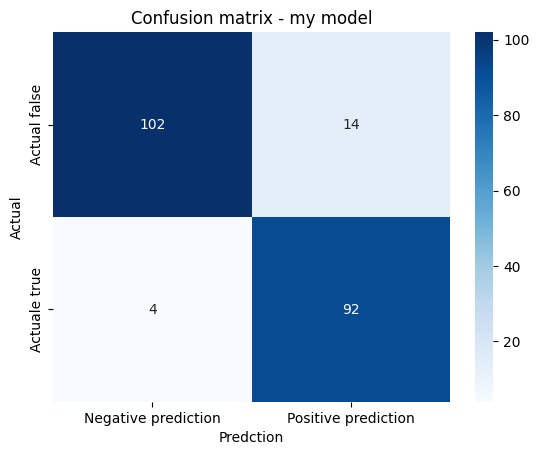

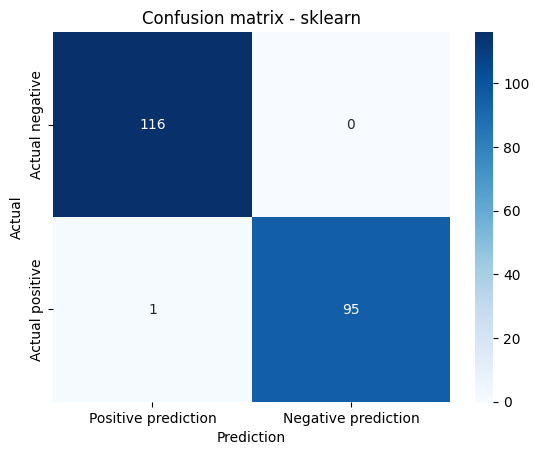

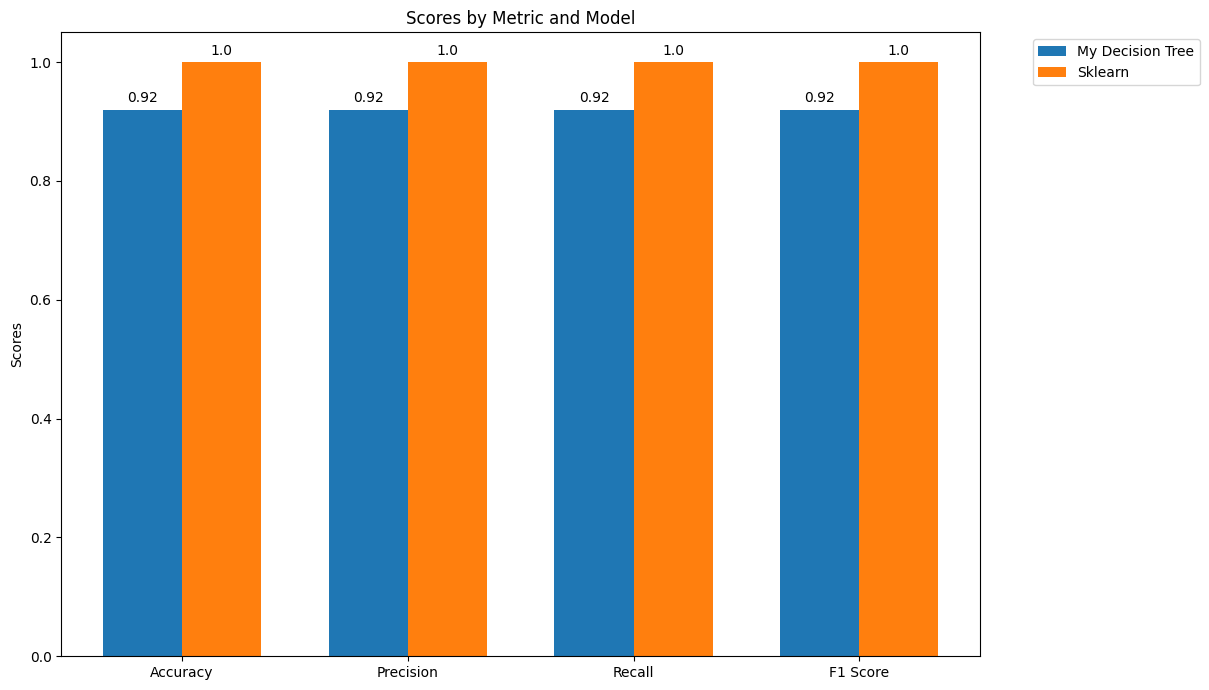

In [ ]:
'''sklearn'''

from sklearn.neighbors import KNeighborsClassifier
from sklearn import metrics

X = dataset_training.loc[:, dataset_training.columns != 'NObeyesdad'].values
Y = dataset_training.loc[:, dataset_training.columns == 'NObeyesdad'].values
Z = dataset_test.loc[:, dataset_test.columns != 'NObeyesdad'].values

knn = KNeighborsClassifier(n_neighbors=k)
# Addestra il classificatore sui dati di addestramento
Y[Y == maximum] = 1
Y[Y == minimum] = 0
knn.fit(X, Y)

sklearn_prediction = knn.predict(Z)

# Output test values sticked to 0 and 1
test_column = dataset_test['NObeyesdad'].values
test_column[test_column == maximum] = 1
test_column[test_column == minimum] = 0

'''My prediction'''
my_prediction[my_prediction == maximum] = 1
my_prediction[my_prediction == minimum] = 0

'''My metrics'''
accuracy = metrics.accuracy_score(test_column, my_prediction)
cm = metrics.confusion_matrix(test_column, my_prediction)
precision = metrics.precision_score(test_column, my_prediction, average='weighted')
recall = metrics.recall_score(test_column, my_prediction, average='weighted')
f1_score = metrics.f1_score(test_column, my_prediction, average='weighted')

'''Sklearn metrics'''
sklearn_prediction = model.predict(Z)
sk_accuracy = metrics.accuracy_score(test_column, sklearn_prediction)
sk_cm = metrics.confusion_matrix(test_column, sklearn_prediction)
sk_precision = metrics.precision_score(test_column, sklearn_prediction, average='weighted')
sk_recall = metrics.recall_score(test_column, sklearn_prediction, average='weighted')
sk_f1_score = metrics.f1_score(test_column, sklearn_prediction, average='weighted')


'''Confusion matrix my model'''
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Negative prediction', 'Positive prediction'], yticklabels=['Actual false', 'Actuale true'])
plt.xlabel('Predction')
plt.ylabel('Actual')
plt.title('Confusion matrix - my model')
plt.show()

'''Confusion matrix sklearn'''
sns.heatmap(sk_cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Positive prediction', 'Negative prediction'], yticklabels=['Actual negative', 'Actual positive'])
plt.xlabel('Prediction')
plt.ylabel('Actual')
plt.title('Confusion matrix - sklearn')
plt.show()

my_metrics = [round(accuracy, 2), round(precision, 2), round(recall, 2), round(f1_score, 2)]
sklearn_metrics = [round(sk_accuracy, 2), round(sk_precision, 2), round(sk_recall, 2), round(sk_f1_score, 2)]

# Etichette per le metriche
labels = ['Accuracy', 'Precision', 'Recall', 'F1 Score']

# Per il grafico a barre
x = np.arange(len(labels))  # the label locations
width = 0.35  # the width of the bars

fig, ax = plt.subplots(figsize=(10, 7))

rects1 = ax.bar(x - width/2, my_metrics, width, label='My Decision Tree')
rects2 = ax.bar(x + width/2, sklearn_metrics, width, label='Sklearn')

# Aggiunta di etichette, titolo e legenda
ax.set_ylabel('Scores')
ax.set_title('Scores by Metric and Model')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()

# Funzione per aggiungere le etichette ai dati
def autolabel(rects):
    """Attach a text label above each bar in *rects*, displaying its height."""
    for rect in rects:
        height = rect.get_height()
        ax.annotate('{}'.format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')

autolabel(rects1)
autolabel(rects2)

fig.tight_layout()

# Aggiungi alcune etichette di testo, titolo e legenda
ax.set_ylabel('Scores')
ax.set_title('Scores by Metric and Model')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()




# Neural Network
- Here neural networks are used to compute a linear regression.
- The training consists in two parts:
    - feedforwarding: the input traversates from left to right the network, computing the multiplication between the weight and the input. Then for every node, an activation function is used to make the mode non-linear.
    - Backpropagation: Based on the loss of the last node, using the chaining rule, the error is backpropagate through all the layer, giving the opportunity to the model to update the weights.
- To tune the hyperparameters i performed a grid search. As 0.01 is the fixed value for the learning rate, the  variables used for the grid search are epocs, number of layers and nodes per layer.

In [133]:
'''REGRESSION'''

'''Downloading dataset'''
dataset = dataset0

'''Dataset sampling'''
dataset = dataset.sample(frac=1, ignore_index=True) #shuffle sample in the training set

'''mapping delle stringhe'''
dataset = pd.get_dummies(dataset, drop_first=True, dtype=float)

'''normalization'''
dataset = (dataset-dataset.mean())/dataset.std()

'''Inserimento colonna di bias'''
dataset.insert(0, "Bias", np.ones(len(dataset)), True) #Bias row


#Splitting dataset
TRAIN_SPLIT_PERCENTAGE = 0.8
VALIDATION_SPLIT_PERCENTAGE = 0.1
TEST_SPLIT_PERCENTAGE = 0.1
dataset_training = dataset[:int(len(dataset) * TRAIN_SPLIT_PERCENTAGE)]
dataset_validation = dataset[int(len(dataset) * TRAIN_SPLIT_PERCENTAGE):int(len(dataset) * (TRAIN_SPLIT_PERCENTAGE + VALIDATION_SPLIT_PERCENTAGE))]
dataset_test = dataset[int(len(dataset) * (TRAIN_SPLIT_PERCENTAGE + VALIDATION_SPLIT_PERCENTAGE)):]


In [134]:
'''REGRESSION'''

output_string = 'Weight'
input_totale = dataset_training.loc[:len(dataset_training), dataset_training.columns != output_string]
output_totale = dataset_training.loc[:len(dataset_training), dataset_training.columns == output_string]

class NeuralNetwork:
    def __init__(self, learning_rate, len_input, num_layers, num_layer_nodes, epochs=1, output_totale=None):
        self.epochs = epochs
        self.learning_rate = learning_rate
        self.len_input = len_input
        self.num_layers = num_layers
        self.num_layer_nodes = num_layer_nodes
        self.weight_list = []
        self.layer_list = []
        self.derivate_list = []
        self.threshold = 0.5
        self.totalerror = 0
        self.output_totale = output_totale


        #weights initialization
        for i in range(self.num_layers-1):
            new_matrix = np.random.rand(self.num_layer_nodes[i], self.num_layer_nodes[i+1]) #matrix with row=i and column i+1: (input,output) of a layer
            self.weight_list.append(new_matrix)

        #Layer initialization
        for i in range(self.num_layers):
            self.layer_list.append(np.zeros(self.num_layer_nodes[i]))

        #partial derivative initialization
        for i in range(self.num_layers-1): #input layer is non counted
            self.derivate_list.append(np.zeros(self.num_layer_nodes[i+1]))



    def activation(self, x, type='sigmoid'): 
        if type=='sigmoid':
            return 1/(1+np.exp(-x))
        return None

    def activation_derivate(self, x, type='sigmoid'):
        if type=='sigmoid':
            return (1-self.activation(x, type='sigmoid'))*self.activation(x, type='sigmoid')
        return None
    
    def training(self, dataset_training):
        for e in range(self.epochs):
            for i in range(dataset_training.shape[0]): #ciclo che itera per ogni sample del dataset 
                sample = dataset_training.loc[i:i]
                self.feedforwarding(sample)
                self.backpropagation(i)



    def testing(self, dataset_testing) -> list: 
        predicted_out = []
        for i in range(dataset_testing.shape[0]):
            self.feedforwarding(dataset_testing.loc[i:i])
            predicted_out.append(self.layer_list[-1][0][0])

        return predicted_out

    def feedforwarding(self, sample):
        '''fase di feedforwarding'''
        self.layer_list[0] = sample.values #inizializzo l'input della rete ai valori del sample
        for layer_index in range(self.num_layers-1): # per ogni weight_matrix esistente
            out_unactivated = np.dot(self.layer_list[layer_index], self.weight_list[layer_index])
            if layer_index < self.num_layers-2:
                self.layer_list[layer_index+1] = self.activation(out_unactivated)
            else:
                self.layer_list[layer_index+1] = out_unactivated

    def backpropagation(self, i): 
        '''fase di backpropagation'''

        error = -(self.output_totale.loc[i:i]-self.layer_list[-1]).values 
        self.derivate_list[-1] = error*self.activation_derivate(self.layer_list[-1])
        
        for j in range(self.num_layers-2, 0, -1): #3-2 layer: si parte dall'indice 1 con 0 escluso (es.)
            ad = self.activation_derivate(self.layer_list[j])
            
            summatory = np.dot(self.derivate_list[j], self.weight_list[j].T )
            self.derivate_list[j-1] = ad*summatory
            '''weight update'''
            self.weight_list[j] -= self.learning_rate*np.matmul(self.layer_list[j].T, self.derivate_list[j])
    
        self.weight_list[0] -= self.learning_rate*np.matmul(self.layer_list[0].T, self.derivate_list[0])
    
    def MSE(self, input_, prediction):
        return (input_-prediction)**2
    
    def dataset_MSE(self, prediction, output):
        return np.mean(self.MSE(prediction, output))
    

epochs = 10
learning_rate = 0.01
len_input = len(input_totale.columns)


In [135]:
'''grid search'''
#real values
e = 10, 20, 30 # epochs
num_layers_list = 3, 4, 5 #number of total layers
num_layers_nodes_list = [5, 10, 15] #number of nodes in each layer


#initialize the grid search
errors = np.zeros((len(e), len(num_layers_list), len(num_layers_nodes_list), 1)) #3D array to store the errors
test_results = np.zeros((len(e), len(num_layers_list), len(num_layers_nodes_list), 1)) #3D array to store the errors

dataset_validation = dataset_validation.reset_index(drop=True)
X_validation = dataset_validation.loc[:, dataset_validation.columns != output_string]
output_training = np.array(dataset_training.loc[:, dataset_training.columns == output_string])
output_validation = dataset_validation.loc[:, dataset_validation.columns == output_string].values.ravel()
weights = []

for i in range(len(e)):
    for h in range(len(num_layers_nodes_list)):
        for g in range(len(num_layers_list)):
            '''Here training+validation. The results are saved in hyperparameter_list'''
            
            '''creating list for layer nodes'''
            num_layer_nodes_input = [len_input]
            for j in range(num_layers_list[g]-2):
                num_layer_nodes_input.append(num_layers_nodes_list[h])
            num_layer_nodes_input.append(1)

            
            n1 = None
            n1 = NeuralNetwork(learning_rate=0.01, len_input=len_input, 
                            num_layers=num_layers_list[g], 
                            num_layer_nodes=num_layer_nodes_input, 
                            epochs=e[i], output_totale=output_totale)
            n1.training(input_totale)
            '''Inserisco in hyperparameter_list il risultato del testing'''
            error = np.mean((n1.testing(X_validation)-output_validation)**2)
            errors[i][h][g] = error
            
            
      

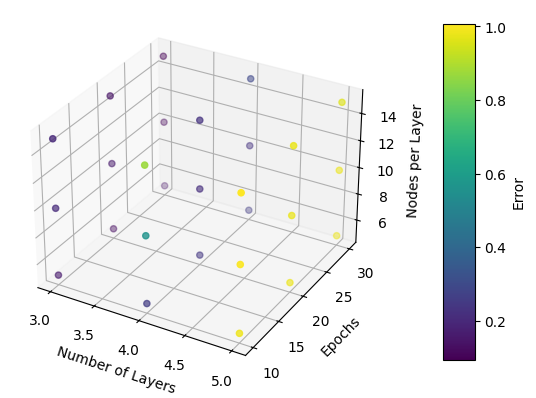

In [136]:
layer, e_list, nodes_list, error_list = [], [], [], []
error_threshold = 20 #This threshold is used to identify divergent outputs
outliers = []

for i in range(len(e)):
    for h in range(len(num_layers_nodes_list)):
        for g in range(len(num_layers_list)):
            error_value = errors[i, h, g][0]
            if error_value < error_threshold:
                layer.append(num_layers_list[g])
                e_list.append(e[i])
                nodes_list.append(num_layers_nodes_list[h])
                error_list.append(error_value)
            else:
                #outliers are put in a separate list
                outliers.append((e[i], num_layers_nodes_list[h], num_layers_list[g], error_value))

# Create a 3D scatter plot
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# Plotting the data
sc = ax.scatter(layer, e_list, nodes_list, c=error_list, cmap='viridis')

# Plotting the outliers with a different color and marker
if len(outliers) > 0:
    outliers_layer, outliers_e, outliers_nodes, outliers_error = zip(*outliers)
    ax.scatter(outliers_layer, outliers_e, outliers_nodes, c='red', marker='x')

# Adding labels
ax.set_xlabel('Number of Layers')
ax.set_ylabel('Epochs')
ax.set_zlabel('Nodes per Layer')

# Adjust the position of the colorbar
fig.subplots_adjust(right=0.8)  # Adjust the right boundary of the plot window
cbar_ax = fig.add_axes([0.85, 0.15, 0.05, 0.7])  # Add an axes at position [left, bottom, width, height]
colorbar = fig.colorbar(sc, cax=cbar_ax)  # Draw the colorbar in the newly created axes
colorbar.set_label('Error')

# Show plot
plt.show()

# Results
- The minimum errors are found with lower number of layers and overall more nodes per layer. It seems also that the less the epoch the less the error.

3 30 15 [29, 15, 1]
0.08503931180129076


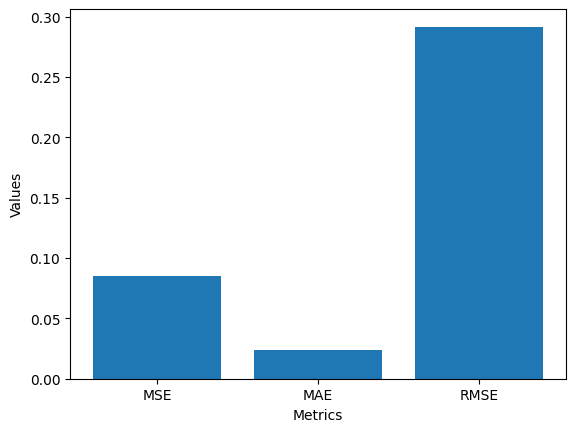

In [141]:
'''Let's use the best hyperparameters on the test set'''
# Getting indexes of the best hyperparameters
min_error_index = error_list.index(min(error_list))

# Estraggo i migliori iperparametri
best_layer = layer[min_error_index]
best_e = e_list[min_error_index]
best_nodes_per_layer = nodes_list[min_error_index]

'''creating list for layer nodes'''
num_layer_nodes_input = [len_input]
for j in range(best_layer-2):
    num_layer_nodes_input.append(best_nodes_per_layer)
num_layer_nodes_input.append(1)

print(best_layer, best_e, best_nodes_per_layer, num_layer_nodes_input)

output_string = 'Weight'
dataset_test = dataset_test.reset_index(drop=True)
X_test = dataset_test.loc[:, dataset_test.columns != 'Weight']

Y_test = np.array(dataset_test['Weight'])
input_totale = dataset_training.loc[:len(dataset_training), dataset_training.columns != output_string]
output_totale = dataset_training.loc[:len(dataset_training), dataset_training.columns == output_string]

# Re-training the model with the best hyperparameters

n2 = NeuralNetwork(learning_rate=0.01, len_input=len_input, 
                    num_layers=best_layer, 
                    num_layer_nodes=num_layer_nodes_input,
                    epochs=best_e, output_totale=output_totale)
n2.training(input_totale)
test_results = n2.testing(X_test)


mse = np.mean((test_results - Y_test) ** 2)
print(mse)
mae = abs(np.mean((test_results - Y_test)))
rmse = mse ** 0.5

metriche = ['MSE', 'MAE', 'RMSE']
values = [mse, mae, rmse]

plt.bar(metriche, values)
plt.xlabel('Metrics')
plt.ylabel('Values')
plt.show()